<center><font size = "10"> Week 11 - Networks <center>
<center><font size = "8">Tutorial 02: External Stimulation <center>
    


In this tutorial we will see the effect of an external stimulus on a small network.

In [1]:
!nrnivmodl

/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_11-20241208
Mod files: "./vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../vecevent.mod
 -> Compiling mod_func.cpp
Translating vecevent.mod into /Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Tutorial_11-20241208/x86_64/vecevent.c
Notice: Use of POINTER is not thread safe.
Notice: VERBATIM blocks are not thread safe
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
 -> Compiling vecevent.c
vecevent.c:43:18: warning: a function declaration without a prototype is deprecated 

In [2]:
from neuron import h
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

np.random.seed(0)
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("stdlib.hoc")
        h.load_file("import3d.hoc")
        if filename.endswith('.asc'):
            morph_reader = h.Import3d_Neurolucida3()
        else:
            morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(
            self
        )  # Notice this change to be able to instantiate several cells
        # all_sections should have the same order as neurom
        self.all_sections = self.soma + self.axon + self.dend
        if hasattr(self, 'apic'):
            self.all_sections += self.apic
        print(len(self.dend), len(self.all_sections))
        self.efferent_synapses = []
        self.afferent_synapses = []

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

--No graphics will be displayed.


In [3]:
Pyr1 = Cell("Pyr_01.swc", "Pyr1", "Pyr")
Pyr2 = Cell("Pyr_02.swc", "Pyr2", "Pyr")
Int1 = Cell("Int_01.swc", "Int1", "Int")
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

34 217
61 347
21 548


In [4]:
connprobs = np.array([[0.7, #pyr-pyr 
                       0.9], # pyr-int,
                      [0.8, # int-pyr
                       0]]) # int-int

syn_per_conn = np.array([[2, 3], [4, 2]])

synapses = []
for pregid, pre in enumerate(cells):
    for postgid, post in enumerate(cells):
        if pre == post:
            continue
        if pre in cells_Pyr:
            i = 0
        else:
            i = 1
        if post in cells_Pyr:
            j = 0
        else:
            j = 1
        connprob = connprobs[i, j]
        if np.random.uniform(0, 1) > connprob:
            continue
        if hasattr(post, 'apic'):
            post_cell_dends = post.dend + post.apic
        else:
            post_cell_dends = post.dend
        post_cell_offset = 1 + len(post.axon)
        print(len(post.all_sections), len(post.dend), len(post_cell_dends), post_cell_offset, len(post_cell_dends) + post_cell_offset)
        for _ in range(syn_per_conn[i, j]):
            # done this way because it's similar to the data you will work with
            synapses.append({
                '@source_node': int(pregid),
                '@target_node': int(postgid),
                'efferent_section_id': np.random.randint(1, 1 + len(pre.axon)),
                'afferent_section_id': np.random.randint(post_cell_offset, post_cell_offset + len(post_cell_dends)),
                'afferent_section_pos': np.random.uniform(0, 1), 
                'efferent_section_pos': np.random.uniform(0, 1)})

            
synapses = pd.DataFrame(synapses)
synapses

347 61 176 171 347
548 21 21 527 548
548 21 21 527 548
217 34 47 170 217
347 61 176 171 347


,@source_node,@target_node,efferent_section_id,afferent_section_id,afferent_section_pos,efferent_section_pos
0,0,1,118,238,0.857946,0.847252
1,0,1,22,207,0.297535,0.056713
2,0,2,40,541,0.568045,0.925597
3,0,2,78,535,0.087129,0.020218
4,0,2,80,542,0.870087,0.473608
5,1,2,148,541,0.720633,0.582020
6,1,2,128,527,0.521848,0.414662
7,1,2,164,538,0.736918,0.216550
8,2,0,54,175,0.612096,0.616934
9,2,0,336,174,0.681820,0.359508


In [5]:
def place_synapse(pre_cell, post_cell, synapse_data):

    post_segment = post_cell.all_sections[int(synapse['afferent_section_id'])](synapse['afferent_section_pos'])
    pre_section = pre_cell.all_sections[int(synapse['efferent_section_id'])]
    pre_segment = pre_section(synapse['efferent_section_pos'])
    syn = h.ExpSyn(post_segment)
    nc = h.NetCon(pre_segment._ref_v, syn, sec=pre_section)
    nc.weight[0] = 0.5
    nc.delay=5 # a 5ms delay gives us more interpretable results, but be aware synaptic transmission is usually a lot faster
    pre_cell.efferent_synapses.append(syn)
    post_cell.afferent_synapses.append(syn)

    return syn, nc


synapse_models = []
netcons = []
for _, synapse in synapses.iterrows():
    source = cells[int(synapse['@source_node'])]
    target = cells[int(synapse['@target_node'])]
    syn, nc = place_synapse(source, target, synapse)
    synapse_models.append(syn)
    netcons.append(nc)

In [6]:
def run_simulation(simulation_time):
    Vm = []
    for cell in cells:
        v = h.Vector()
        v.record(cell.soma[0](0.5)._ref_v)
        Vm.append(v)


    time = h.Vector()
    time.record(h._ref_t)


    h.finitialize(-65)
    h.load_file('stdrun.hoc')
    h.continuerun(simulation_time)
    return Vm, time

In [7]:
def connectivity_plot(axis, synapses, cells_df):
    for (pre, post), conn in synapses.reset_index().groupby(['@source_node', '@target_node'])['index'].count().items():
        axis.plot([0, 1], [pre, post], linewidth=conn, color='red' if cells_df.loc[pre, 'morph_class'] == 'INT' else 'blue')
    axis.set_yticks(range(len(cells_df)))
    axis.set_xticks([])

def spike_raster(Vm, time, axis):
    for i, v in enumerate(Vm):
        spiketimes = spike_detector(np.array(v), -20, np.array(time))
        axis.scatter(spiketimes, [i] * len(spiketimes), marker='|', color='k')
    axis.set_xlabel("time (ms)")

    
def plot_results(Vm, time, cells_df):
    f, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
    
    connectivity_plot(axes[0], synapses, cells_df)
    spike_raster(Vm, time, axes[1])
    
    plt.ylabel('Neuron')
    return f, axes


def spike_detector(voltage, threshold, time):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return time[spike_time]

# External stimulation

We are going to add some synapses representing input from a distant brain region.
In this case all our synapses will fire with the exact same timing: representing input from a single external cell onto multiple cells in the model.

We are assuming a connection probability of 0.5

In [8]:
simulation_time = 500

stim_start = 0
stim_end = 500

external_synapses = []
ext_netcons = []
ext_stims = []
connprob = 0.6
ext_spike_trains = [] 
stimulated_nrns = []
rate = 10 # Hz
ext_spikes = stim_start + np.random.exponential(1000/rate, size=100).cumsum() # poisson train
ext_spikes = ext_spikes[ext_spikes < stim_end]
stimulated = []
for i, cell in enumerate(cells):
    if np.random.uniform(0, 1) > connprob:
        continue
    stimulated.append(i)
    syn = h.ExpSyn(cell.soma[0](0.5))
    stim = h.VecStim()
    stim.play(h.Vector(ext_spikes))
    nc = h.NetCon(stim, syn)
    nc.weight[0] = 0.5
    nc.delay = 0
    external_synapses.append(syn)
    ext_netcons.append(nc)
    ext_stims.append(stim)
    ext_spike_trains.append(ext_spikes)
    stimulated_nrns.append(i)



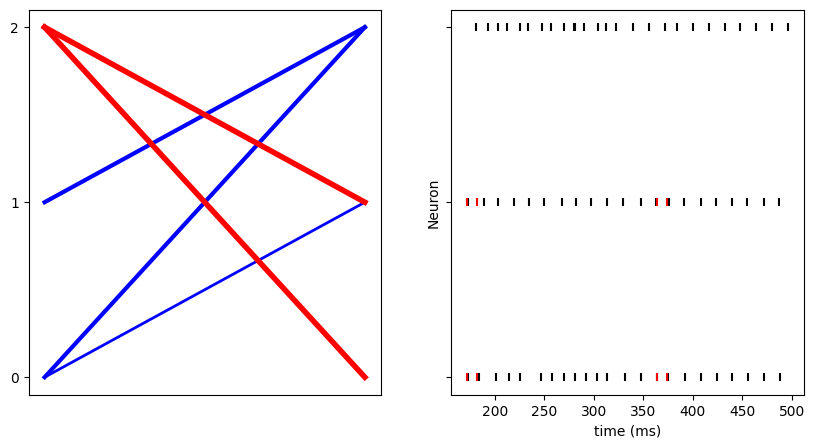

In [9]:
Vm, time = run_simulation(simulation_time)

f, a = plot_results(Vm, time, pd.DataFrame({'morph_class': ['PYR', 'PYR', 'INT']}))
for i in stimulated:
    a[1].scatter(ext_spikes, [i] * len(ext_spikes), color='r', marker='|')